In [1]:
%load_ext autoreload
%autoreload 2
from Ge_calculation import GAP, MD_run
from Ge_analysis import *
import pickle
from ase.io.cfg import read_cfg
import numpy as np
import os
from ase import build
from ase.atoms import Atoms
from quippy.potential import Potential
from quippy.descriptors import Descriptor
from copy import deepcopy
from ase.io.extxyz import read_xyz, write_xyz
import pandas as pd
from sklearn import decomposition
import matplotlib.pyplot as plt

In [2]:
os.chdir('/home/joe/Documents/Ge_od/Potentials/Si_myDB_reduction_testing')

In [3]:
def reduce_DB(xyz, gen_red=1, ctypes = [None], outfile=None, size_dep_prob={}):
    '''Reduces a database's configuration count for robustness stress-testing
    ctypes: list of str, config_types to keep in new DB. Leave None for all
    size_dist: dict, sizes and their desired relative fractions
    outfile: str, optional custom name for new DB file'''
    r = np.random.rand
    ats = list(read_xyz(xyz, index=slice(0,None)))
    sizes = np.unique([len(i) for i in ats])
    for i in sizes:
        if str(i) not in size_dep_prob.keys():
            size_dep_prob.update({str(i):1})
    ini = sum([len(i) for i in ats])
    keeps = []
    ct = 0; ct_kept = 0; popped = []

    for i in range(len(ats)-1, -1, -1):
        if r() > gen_red and len(ats[i]) != 1:
            popped.append(ats.pop(i))

    for i in range(len(ats)-1, -1, -1):
        if r() > size_dep_prob[str(len(ats[i]))]:
            popped.append(ats.pop(i))

    for i, val in enumerate(ats):
        if (val.info['config_type'] in ctypes or 'isol' in val.info['config_type'] or None in ctypes):
            keeps.append(val)
        else:
            popped.append(val)


    if outfile is None:
        outfile = xyz.split('.')[:-1] + '_red.xyz'
        valfile = xyz.split('.')[:-1] + '_extraval.xyz'

    write_xyz(outfile, keeps)

    print('total {0} popped\n'.format(len(popped)))
    print('final fraction = {:2.2f}%'.format(100*sum([len(i) for i in keeps])/ini))
    print_DB_stats(keeps)

    return keeps, popped

In [4]:
def print_DB_stats(atoms, by_config_type=True):
    print('Size statistics:\n'+'-'*36)
    if isinstance(atoms[0], list):
        atoms = flatten(atoms)
    hist = [len(i) for i in atoms]
    tot = sum(hist)
    sizes, freq = np.unique(hist, return_counts=True)
    print(('{:<12s}'*3).format('size', 'freq', 'percentage'))
    for j in range(len(sizes)):
        print('{:<12d}{:<12d}{:<11.1f}'.format(sizes[j], freq[j], 100*sizes[j]*freq[j]/tot))

    if by_config_type:
        labels = []
        catoms = []
        for i in atoms:
            if 'config_type' in i.info.keys():
                if (l := i.info['config_type']) not in labels:
                    labels.append(l)
                    catoms.append([])
                catoms[labels.index(l)].append(i)
        print('\nBy config types:\n'+'-'*36)
        for i, val in enumerate(catoms):
            hist = [len(j) for j in val]
            tot = sum(hist)
            sizes, freq = np.unique(hist, return_counts=True)
            print('{:<16s} {} atoms'.format(val[0].info['config_type'], tot))
            for j in range(len(sizes)):
                print('{:<12d}{:<12d}{:<11.1f}'.format(sizes[j], freq[j], 100*sizes[j]*freq[j]/tot))
            print('-'*36+'\n')
    return

In [39]:
# my = GAP('Si_myDB_64_125_216_train.xyz',
#          val_file='Si_myDB_64_125_216_validate.xyz',
#          pot='/home/joe/Documents/Ge_od/Potentials/Si_myDB_216/Si_myDB_liqamo_loose.xml')

In [10]:
print_DB_stats(list(read_xyz('Si_myDB_64_125_216_train.xyz', index=slice(0,None))))

Size statistics:
------------------------------------
size        freq        percentage  
1           1           0.0        
64          200         48.4       
125         40          18.9       
216         40          32.7       

By config types:
------------------------------------
isol             1 atoms
1           1           100.0      
------------------------------------

amorph           5288 atoms
64          40          48.4       
125         8           18.9       
216         8           32.7       
------------------------------------

inter            5288 atoms
64          40          48.4       
125         8           18.9       
216         8           32.7       
------------------------------------

hiT_amorph       5288 atoms
64          40          48.4       
125         8           18.9       
216         8           32.7       
------------------------------------

liq              5288 atoms
64          40          48.4       
125         8           1

Trying various reductions in DB size to see where failure occurs
* use loose gap_fit default_sigma
* automatic run of 64-atom quench at the end

Ideas:
* amorphous only
* liquid only
* 75%, 50%, 25% reduction
* 64-atom cells only


In [63]:
lk, lp = reduce_DB('Si_myDB_64_125_216_train.xyz', ctypes=['liq', 'inter', 'hiT_liq'],
                   outfile='Si_myDB_64_125_216_t_liq.xyz')
ak, ap = reduce_DB('Si_myDB_64_125_216_train.xyz', ctypes=['amorph', 'hiT_amorph'],
                   outfile='Si_myDB_64_125_216_t_amo.xyz')
r75k, r75p = reduce_DB('Si_myDB_64_125_216_train.xyz', gen_red=0.75,
                   outfile='Si_myDB_64_125_216_t_r75.xyz')
r50k, r50p = reduce_DB('Si_myDB_64_125_216_train.xyz', gen_red=0.5,
                   outfile='Si_myDB_64_125_216_t_r50.xyz')
r25k, r25p = reduce_DB('Si_myDB_64_125_216_train.xyz', gen_red=0.25,
                   outfile='Si_myDB_64_125_216_t_r25.xyz')
cell64k, cell64p = reduce_DB('Si_myDB_64_125_216_train.xyz', size_dep_prob={'125':0, '216':0},
                             outfile='Si_myDB_64_125_216_64at.xyz')

total 112 popped

config_types removed: ['amorph', 'hiT_amorph']


In [9]:
print_DB_stats(list(read_xyz('Si_myDB_64_125_216_t_amo.xyz', index=slice(0,None))))

Size statistics:
------------------------------------
size        freq        percentage  
1           1           0.0        
64          80          48.4       
125         16          18.9       
216         16          32.7       

By config types:
------------------------------------
isol             1 atoms
1           1           100.0      
------------------------------------

amorph           5288 atoms
64          40          48.4       
125         8           18.9       
216         8           32.7       
------------------------------------

hiT_amorph       5288 atoms
64          40          48.4       
125         8           18.9       
216         8           32.7       
------------------------------------



In [8]:
print_DB_stats(list(read_xyz('Si_myDB_64_125_216_t_liq.xyz', index=slice(0,None))))

Size statistics:
------------------------------------
size        freq        percentage  
1           1           0.0        
64          120         48.4       
125         24          18.9       
216         24          32.7       

By config types:
------------------------------------
isol             1 atoms
1           1           100.0      
------------------------------------

inter            5288 atoms
64          40          48.4       
125         8           18.9       
216         8           32.7       
------------------------------------

liq              5288 atoms
64          40          48.4       
125         8           18.9       
216         8           32.7       
------------------------------------

hiT_liq          5288 atoms
64          40          48.4       
125         8           18.9       
216         8           32.7       
------------------------------------



In [12]:
print_DB_stats(list(read_xyz('Si_myDB_64_125_216_64at.xyz', index=slice(0,None))))

Size statistics:
------------------------------------
size        freq        percentage  
1           1           0.0        
64          200         100.0      

By config types:
------------------------------------
isol             1 atoms
1           1           100.0      
------------------------------------

amorph           2560 atoms
64          40          100.0      
------------------------------------

inter            2560 atoms
64          40          100.0      
------------------------------------

hiT_amorph       2560 atoms
64          40          100.0      
------------------------------------

liq              2560 atoms
64          40          100.0      
------------------------------------

hiT_liq          2560 atoms
64          40          100.0      
------------------------------------



## Collate the reduced MD runs

In [3]:
red_MD_dirs = [i for i in os.listdir() if 'run_64' in i]
red_MDs = [MD_run(i, label=i[26:]) for i in red_MD_dirs]

In [4]:
mlp_red_MD_dirs = [i for i in os.listdir('mlp') if 'run_1000' in i]
mlp_red_MDs = [MD_run(os.path.join('mlp',i), label='mlp_'+i[26:]) for i in mlp_red_MD_dirs]

In [5]:
for i in red_MDs:
    i.structure_factors(selection=[i for i in range(30,120)]+[i for i in range(220,240)],
                    rings_dir='Sq_'+i.label,
                    opts={'Angles':True},
                    rings_in={'species':['Si']},
                    read_only=True)
    l_sel = [i for i in range(90)]
    a_sel = [i for i in range(90,110)]
    i.bin_fit(s_selection=l_sel, q_selection=[0.5,12])
    i.bin_fit(s_selection=a_sel, q_selection=[0.5,12])
    i.bin_bond_angle(s_selection=l_sel)
    i.bin_bond_angle(s_selection=a_sel)

In [6]:
for i in mlp_red_MDs:
    i.structure_factors(selection=[i for i in range(30,120)]+[i for i in range(220,240)],
                    rings_dir='mlp/Sq_'+i.label,
                    opts={'Angles':True},
                    rings_in={'species':['Si']},
                    read_only=True)
    l_sel = [i for i in range(90)]
    a_sel = [i for i in range(90,110)]
    i.bin_fit(s_selection=l_sel, q_selection=[0.5,12])
    i.bin_fit(s_selection=a_sel, q_selection=[0.5,12])
    i.bin_bond_angle(s_selection=l_sel)
    i.bin_bond_angle(s_selection=a_sel)

## Get some reference data: BADFs, structure factors, and coordination statistics
These are saved now as csv files for use in other notebooks

In [7]:
#experimental data
lSi_exp_Sq = np.genfromtxt('/home/joe/Documents/Ge_od/paper_data/Si_Sq_exp_Waseda1974.txt',
                          delimiter=', ').T
lSi_exp_Sq[1] += -0.5

aSi_exp_Sq = np.genfromtxt('/home/joe/Documents/Ge_od/paper_data/a-Si_x-ray_Laaziri1999.txt',
                          delimiter=', ').T
aSi_exp_gr = np.genfromtxt('/home/joe/Documents/Ge_od/paper_data/aSi-g-Lannin1988.txt',
                          delimiter=', ').T
Si_exp_lADF = np.genfromtxt('/home/joe/Documents/Ge_od/paper_data/l-Si_ADF_Bartok2018_DFT.txt',
                          delimiter=', ').T
Si_exp_lADF_GAP = np.genfromtxt('/home/joe/Documents/Ge_od/paper_data/l-Si_ADF_Bartok2018_GAP.txt',
                          delimiter=', ').T
Si_exp_RDF = np.genfromtxt('/home/joe/Documents/Ge_od/paper_data/l-Si_RDF_Bartok2018_DFT.txt',
                          delimiter=', ').T
Si_lGAP_RDF = np.genfromtxt('/home/joe/Documents/Ge_od/paper_data/l-Si_RDF_Bartok2018_GAP.txt',
                          delimiter=', ').T

In [8]:
Si_loomy_GAP1000_MD = MD_run('../../MD_runs/Si_my_DB_216/run_1000_001', label='loose GAP myDB 1000')
Si_mlp1000_MD = MD_run('../../MD_runs/mlip/my/run_1000_Si_myDB_liqamo_216_full', label='MTP myDB 1000')
Si_litDB_full = MD_run('/home/joe/Documents/Ge_od/MD_runs/Si_litDB_full_4000/run_1000_001', label='lit. DB full 1000')
Si_mlp64_MD = MD_run('../../MD_runs/mlip/my/run_64_', label='MTP myDB 64')
# Add a SNAP-trained one in here too

In [9]:
Si_litDB_full_64 = MD_run('/home/joe/Documents/Ge_od/MD_runs/Si_litDB_full_4000/run_64001', label='lit. DB full 64')

In [10]:
Si_mlp64_MD.structure_factors(selection=[i for i in range(30,120)]+[i for i in range(220,240)],
                    rings_dir='../../MD_runs/mlip/my/run_64_/Sq_rings/',
                    opts={'Angles':True},
                    rings_in={'species':['Si']},
                    read_only=True,
                    )
Si_mlp64_MD.bin_fit(s_selection=[i for i in range(90)], q_selection=[0.5,12])
Si_mlp64_MD.bin_fit(s_selection=[i for i in range(90, 110)], q_selection=[0.5,12])
Si_mlp64_MD.bin_bond_angle(s_selection=range(90))
Si_mlp64_MD.bin_bond_angle(s_selection=range(90, 110))

Si_mlp1000_MD.structure_factors(selection=[i for i in range(30,120)]+[i for i in range(220,240)],
                    rings_dir='../../MD_runs/mlip/my/run_1000_Si_myDB_liqamo_216_full/Sq_rings/',
                    opts={'Angles':True},
                    rings_in={'species':['Si']},
                    read_only=True,
                    )
Si_mlp1000_MD.bin_fit(s_selection=[i for i in range(90)], q_selection=[0.5,12])
Si_mlp1000_MD.bin_fit(s_selection=[i for i in range(90, 110)], q_selection=[0.5,12])
Si_mlp1000_MD.bin_bond_angle(s_selection=range(90))
Si_mlp1000_MD.bin_bond_angle(s_selection=range(90, 110))

Si_litDB_full.structure_factors(selection=[i for i in range(30,120)]+[i for i in range(220,240)],
                    rings_dir='/home/joe/Documents/Ge_od/MD_runs/Si_litDB_full_4000/Sq_rings_1000_001/',
                    opts={'Angles':True},
                    rings_in={'species':['Si']},
                    read_only=True,
                    )
Si_litDB_full.bin_fit(s_selection=[i for i in range(90)], q_selection=[0.5,12])
Si_litDB_full.bin_fit(s_selection=[i for i in range(90, 110)], q_selection=[0.5,12])
Si_litDB_full.bin_bond_angle(s_selection=range(90))
Si_litDB_full.bin_bond_angle(s_selection=range(90, 110))


Si_litDB_full_64.structure_factors(selection=[i for i in range(30,120)]+[i for i in range(220,240)],
                    rings_dir='/home/joe/Documents/Ge_od/MD_runs/Si_litDB_full_4000/Sq_rings_64001/',
                    opts={'Angles':True},
                    rings_in={'species':['Si']},
                    read_only=True,
                    )
Si_litDB_full_64.bin_fit(s_selection=[i for i in range(90)], q_selection=[0.5,12])
Si_litDB_full_64.bin_fit(s_selection=[i for i in range(90, 110)], q_selection=[0.5,12])
Si_litDB_full_64.bin_bond_angle(s_selection=range(90))
Si_litDB_full_64.bin_bond_angle(s_selection=range(90, 110))

Si_loomy_GAP1000_MD.structure_factors(selection=[i for i in range(30,120)]+[i for i in range(220,240)],
                    rings_dir='../../MD_runs/Si_my_DB_216/run_1000_001/Sq_rings/',
                    opts={'Angles':True},
                    rings_in={'species':['Si']},
                    read_only=True,
                    )
Si_loomy_GAP1000_MD.bin_fit(s_selection=[i for i in range(90)], q_selection=[0.5,12])
Si_loomy_GAP1000_MD.bin_fit(s_selection=[i for i in range(90, 110)], q_selection=[0.5,12])
Si_loomy_GAP1000_MD.bin_bond_angle(s_selection=range(90))
Si_loomy_GAP1000_MD.bin_bond_angle(s_selection=range(90, 110))

In [78]:
Si_litDB_test = MD_run('/home/joe/Documents/Ge_od/MD_runs/Si_litDB_full_4000/run_1000_001', label='lit. DB test 1000')

In [13]:
Si_mlp1000_MD_test = MD_run('../../MD_runs/mlip/my/run_1000_Si_myDB_liqamo_216_full', label='MTP myDB 1000')

In [79]:
# Get the 2500K liquid structure (not supercooled)
for i in range(220, 240): # rescale the bond lengths to have a look at S(Q) shift
    Si_litDB_test.configs[i].set_cell(Si_litDB_test.configs[i].get_cell()*0.95, scale_atoms=True)

In [14]:
Si_mlp1000_MD_test.structure_factors(selection=[i for i in range(10,20)]+[i for i in range(220,240)],
                    rings_dir='../../MD_runs/mlip/my/run_1000_Si_myDB_liqamo_216_full/Sq_rings_1000_001_hiT/',
                    opts={'Angles':True,
                           'Bonds':True},
                    rings_in={'species':['Si'],
                              'cutoffs': [2.7],
                              'Grtot': 2.7},
                    read_only=False,
                    overwrite=True
                    )

R.I.N.G.S ran successfully


In [96]:
Si_litDB_test.structure_factors(selection=[i for i in range(10,20)]+[i for i in range(220,240)],
                    rings_dir='/home/joe/Documents/Ge_od/MD_runs/Si_litDB_full_4000/Sq_rings_1000_001_hiT/',
                    opts={'Angles':True,
                           'Bonds':True,
                          'Rings':True,
                          #'ring_options':{'Rings1':True},
                          'tetraOut':True},
                    rings_in={'species':['Si'],
                              'cutoffs': [2.7],
                              'Grtot': 2.7},
                    read_only=False,
                    overwrite=True
                    )

R.I.N.G.S ran successfully


In [1]:
Si_litDB_test.structure_factors(
                    rings_dir='/home/joe/Documents/Ge_od/MD_runs/Si_litDB_full_4000/run_dia',
                    opts={'Angles':True,
                           'Bonds':True,
                          'Rings':True,
                          #'ring_options':{'Rings1':True},
                          'tetraOut':True},
                    rings_in={'species':['Si'],
                              'cutoffs': [2.7],
                              'Grtot': 2.7},
                    read_only=False,
                    overwrite=True
                    )

NameError: name 'Si_litDB_test' is not defined

In [15]:
Si_mlp1000_MD_test.bin_fit(s_selection=[i for i in range(10)], q_selection=[0.5,12])
Si_mlp1000_MD_test.bin_fit(s_selection=[i for i in range(10,30)], q_selection=[0.5,12])

In [81]:
Si_litDB_test.bin_fit(s_selection=[i for i in range(10)], q_selection=[0.5,12])
Si_litDB_test.bin_fit(s_selection=[i for i in range(10,30)], q_selection=[0.5,12])
# Si_litDB_test.bin_fit_g(s_selection=[i for i in range(10)])
# Si_litDB_test.bin_fit_g(s_selection=[i for i in range(10,30)])

In [10]:
np.savetxt("plot_data/Si_mlp_myDBliqamo_64_MD_liqSq.txt", Si_mlp64_MD.Sq_x_av[0], delimiter=',')
np.savetxt("plot_data/Si_mlp_myDBliqamo_64_MD_amoSq.txt", Si_mlp64_MD.Sq_x_av[1], delimiter=',')
np.savetxt("plot_data/Si_mlp_myDBliqamo_1000_MD_liqSq.txt", Si_mlp1000_MD.Sq_x_av[0], delimiter=',')
np.savetxt("plot_data/Si_mlp_myDBliqamo_1000_MD_amoSq.txt", Si_mlp1000_MD.Sq_x_av[1], delimiter=',')
np.savetxt("plot_data/Si_GAP_litDBfull_1000_MD_liqSq.txt", Si_litDB_full.Sq_x_av[0], delimiter=',')
np.savetxt("plot_data/Si_GAP_litDBfull_1000_MD_amoSq.txt", Si_litDB_full.Sq_x_av[1], delimiter=',')
np.savetxt("plot_data/Si_GAP_myDBliqamo_1000_MD_liqSq.txt", Si_loomy_GAP1000_MD.Sq_x_av[0], delimiter=',')
np.savetxt("plot_data/Si_GAP_myDBliqamo_1000_MD_amoSq.txt", Si_loomy_GAP1000_MD.Sq_x_av[1], delimiter=',')

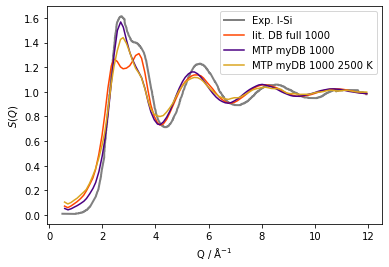

In [16]:
# Effect of temperature on liquid structure
fig, axs = plt.subplots()
axs.errorbar(*Si_litDB_full.Sq_x_av[0], yerr=None,
            label=Si_litDB_full.label, color='orangered')
# axs.errorbar(*Si_litDB_test.Sq_x_av[0], yerr=None,
#             label=Si_litDB_full.label + ' 2500 K', color='k')
axs.errorbar(*Si_mlp1000_MD.Sq_x_av[0], yerr=None,
            label=Si_mlp1000_MD.label, color='Indigo')
axs.errorbar(*Si_mlp1000_MD_test.Sq_x_av[0], yerr=None,
            label=Si_mlp1000_MD_test.label + ' 2500 K', color='goldenrod')
axs.plot(*lSi_exp_Sq, color='Gray', linewidth=2, label='Exp. l-Si')
axs.set(xlabel= r'Q / $\mathrm{{\AA}}^{-1}$', ylabel='$S(Q)$')
axs.legend()
# fig.savefig('/home/joe/OneDrive/slack_figures/Sq-l_methods_1000.png', dpi=100, bbox_inches='tight')
# axs.legend()

Shows there is a difference between the two temperatures. Would be interesting to see yet larger system sizes
and 1800K

Should look at the Td (atomic information) data now (cheap to calc. with R.I.N.G.S)


[(0.0, 12.0)]

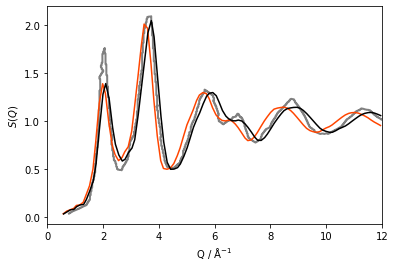

In [83]:
#Effect of lattice scaling on phase of S(Q)
fig, axs = plt.subplots()
axs.errorbar(*Si_litDB_full.Sq_x_av[1], yerr=None,
            label=Si_litDB_full.label, color='orangered')
axs.errorbar(*Si_litDB_test.Sq_x_av[1], yerr=None,
            label=Si_litDB_full.label + ' 0.95 scale', color='k')
axs.plot(*aSi_exp_Sq, color='Gray', linewidth=2, label='Exp. a-Si')
axs.set(xlabel= r'Q / $\mathrm{{\AA}}^{-1}$', ylabel='$S(Q)$')
axs.set(xlim=(0,12))
# fig.savefig('/home/joe/OneDrive/slack_figures/Sq-l_methods_1000.png', dpi=100, bbox_inches='tight')
# axs.legend()

Shows that a difference in bond length is the cause of out-of-phase structure factors


NameError: name 'Si_litDB_test' is not defined

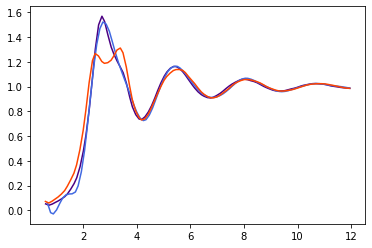

In [12]:
fig, axs = plt.subplots()
axs.errorbar(*Si_mlp1000_MD.Sq_x_av[0], yerr=None,
            label=Si_mlp1000_MD.label, color='Indigo')
axs.errorbar(*Si_mlp64_MD.Sq_x_av[0], yerr=None,
            label=Si_mlp64_MD.label, color='RoyalBlue')
# axs.errorbar(*Si_loomy_GAP1000_MD.Sq_x_av[0], yerr=None,
#             label=r'loose GAP 1000-atom myDB', color='RoyalBlue')
axs.errorbar(*Si_litDB_full.Sq_x_av[0], yerr=None,
            label=Si_litDB_full.label, color='orangered')
axs.errorbar(*Si_litDB_test.Sq_x_av[0], yerr=None,
            label=Si_litDB_full.label + '2500 K', color='orangered')
axs.errorbar(*Si_loomy_GAP1000_MD.Sq_x_av[0], yerr=None,
            label=Si_loomy_GAP1000_MD.label, color='seagreen')
axs.plot(*lSi_exp_Sq, color='Gray', linewidth=2, label='Exp. l-Si')
axs.set(xlabel= r'Q / $\mathrm{{\AA}}^{-1}$', ylabel='$S(Q)$')
# fig.savefig('/home/joe/OneDrive/slack_figures/Sq-l_methods_1000.png', dpi=100, bbox_inches='tight')
axs.legend()

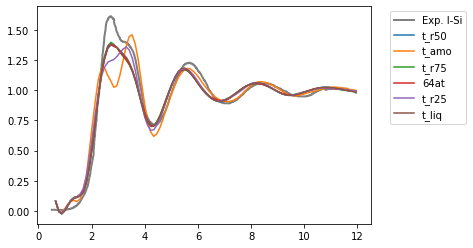

In [36]:
fig, axs = plt.subplots()
for i in red_MDs:
    axs.errorbar(*i.Sq_x_av[0], yerr=None,
                label=i.label)

axs.plot(*lSi_exp_Sq, color='Gray', linewidth=2, label='Exp. l-Si')
axs.legend(bbox_to_anchor=(1.04, 1), loc='upper left')

In [23]:
for i in mlp_red_MDs:
    print(i.label[6:])
for i in red_MDs:
    print(i.label)

t_r50
t_r75
t_liq
t_r25
t_r25
t_r75
64at
t_r50
t_liq
t_amo


In [24]:
for i in red_MDs:
    np.savetxt("plot_data/Si_GAP_myDB_{}_64_MD_liqSq.txt".format(i.label), i.Sq_x_av[0], delimiter=',')
    np.savetxt("plot_data/Si_GAP_myDB_{}_64_MD_amoSq.txt".format(i.label), i.Sq_x_av[1], delimiter=',')
for i in mlp_red_MDs:
    np.savetxt("plot_data/Si_MTP_myDB_{}_64_MD_liqSq.txt".format(i.label[6:]), i.Sq_x_av[0], delimiter=',')
    np.savetxt("plot_data/Si_MTP_myDB_{}_64_MD_amoSq.txt".format(i.label[6:]), i.Sq_x_av[1], delimiter=',')

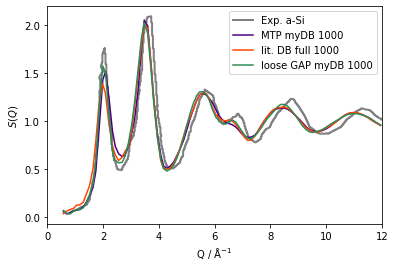

In [47]:
fig, axs = plt.subplots()
axs.errorbar(*Si_mlp1000_MD.Sq_x_av[1], yerr=None,
            label=Si_mlp1000_MD.label, color='Indigo')
# axs.errorbar(*Si_mlp64_MD.Sq_x_av[1], yerr=None,
#             label=Si_mlp64_MD.label, color='RoyalBlue')
# axs.errorbar(*Si_loomy_GAP1000_MD.Sq_x_av[1], yerr=None,
#             label=r'loose GAP 1000-atom myDB', color='Blue')
axs.errorbar(*Si_litDB_full.Sq_x_av[1], yerr=None,
            label=Si_litDB_full.label, color='orangered')
axs.errorbar(*Si_loomy_GAP1000_MD.Sq_x_av[1], yerr=None,
            label=Si_loomy_GAP1000_MD.label, color='seagreen')
axs.plot(*aSi_exp_Sq, color='Gray', linewidth=2, label='Exp. a-Si')
axs.legend()
axs.set(xlabel= r'Q / $\mathrm{{\AA}}^{-1}$', ylabel='$S(Q)$')
axs.set(xlim=(0,12))
fig.savefig('/home/joe/OneDrive/slack_figures/Sq_methods_1000.png', dpi=100, bbox_inches='tight')

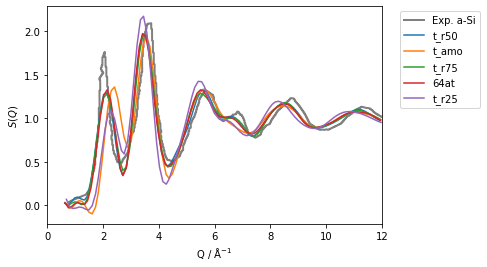

In [48]:
fig, axs = plt.subplots()
for i in red_MDs[:-1]:
    axs.errorbar(*i.Sq_x_av[1], yerr=None,
                label=i.label)

axs.plot(*aSi_exp_Sq, color='Gray', linewidth=2, label='Exp. a-Si')
axs.legend(bbox_to_anchor=(1.04, 1), loc='upper left')
axs.set(xlabel= r'Q / $\mathrm{{\AA}}^{-1}$', ylabel='$S(Q)$')
axs.set(xlim=(0,12))
fig.savefig('/home/joe/OneDrive/slack_figures/Sq_reduction_64_GAP.png', dpi=100, bbox_inches='tight')

Shows that the 50% reduced DB is as good as the full one, 25% fails


In [75]:
MDs = [Si_mlp1000_MD, Si_mlp64_MD, Si_litDB_full, Si_loomy_GAP1000_MD]
MDs.extend(red_MDs)
MDs.append(Si_litDB_full_64)
cns = [cn_count(i.df['Configs'][240000])[1] for i in MDs]

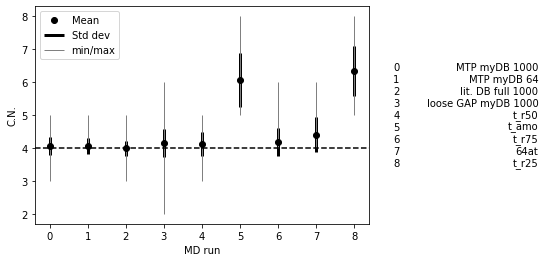

In [256]:
mins = [i.min() for i in cns]
maxs = [i.max() for i in cns]
means = [i.mean() for i in cns]
std = [i.std() for i in cns]
d = range(len(mins))

fig, axs = plt.subplots()
l1 = axs.errorbar(np.arange(n := len(cns)), means, std, fmt='ok', lw=3)
l2 = axs.errorbar(np.arange(n), means, [[means[i] - mins[i] for i in d], [maxs[i] - means[i] for i in d]],
             fmt='.k', ecolor='gray', lw=1)
axs.xaxis.set_major_locator(mpl.ticker.IndexLocator(1, 0))
axs.table(cellText=np.array([np.arange(n), [i.label for i in MDs]]).T,
          edges='', loc=14, colWidths=[0.1,0.45])
axs.set(xlabel='MD run', ylabel='C.N.')
axs.legend([l1[0], l1[2], l2[2]], ('Mean', 'Std dev', 'min/max'), loc='upper left')
axs.axhline(4, color='k', linestyle='--')

In [115]:
list(l1)

 (),
 (<matplotlib.collections.LineCollection at 0x7f63c2a010a0>,)]

Should look for experimental BADF (or at least width)


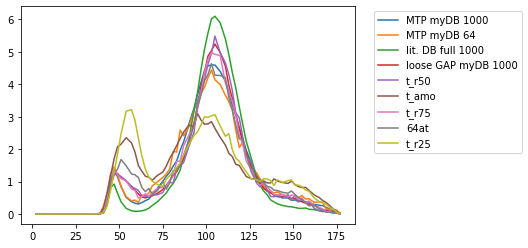

In [248]:
fig, axs = plt.subplots()
for i in MDs:
    axs.plot(*i.bond_angle_av[1], label=i.label)

axs.legend(bbox_to_anchor=(1.04, 1), loc='upper left')


In [25]:
[i.label for i in MDs]

NameError: name 'MDs' is not defined

In [125]:
targets = [0, 2, 3, 7, 6, 4, 8]
targets_GAP = [7, 6, 4, 8]
target_labels = ['MTP myDB 1000',
 'MTP myDB 64',
 'lit. DB full 1000',
 'loose GAP myDB 1000',
 '.. 50%',
 't_amo',
 '.. 75%',
 'loose GAP myDB 64',
 '.. 25%',
 't_liq',
    'lit. DB full 64']
mlp_MDs = [Si_mlp1000_MD, Si_mlp64_MD] + mlp_red_MDs
mlp_target_labels = [
    'MTP 1000 myDB',
    'MTP 1000 myDB',
    '.. 75%',
    '.. 50%',
    '.. 25%'
]
mlp_targets = [0, 2, 3, 4]

colors = ['Indigo',
          'Indigo',
          'Orangered',
          'seagreen',
          'darkorange',
          '',
          'firebrick',
          'seagreen',
          'goldenrod',
          '',
          'Orangered']
mlp_colors = ['Indigo',
          'Indigo',
          'firebrick',
          'darkorange',
          'goldenrod',
          '']

In [126]:
fig_dir = '/home/joe/OneDrive/slack_figures/'

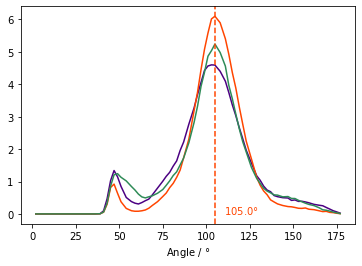

In [136]:
fig, axs = plt.subplots()
for i in targets[:3]:
    axs.plot(*MDs[i].bond_angle_av[1], label=target_labels[i], color=colors[i])

b = Si_litDB_full.bond_angle_av[1]
max = b[0][b[1].argmax()]
axs.axvline(max, color='orangered', linestyle='--')
axs.text(max*1.05, 0, '${} \degree$'.format(str(max)), color='orangered')
#axs.legend(bbox_to_anchor=(1.04, 1), loc='upper left')
axs.set(xlabel='Angle / $\degree$')
fig.savefig('/home/joe/OneDrive/slack_figures/ang_methods_1000.png', dpi=100, bbox_inches='tight')

# Assessing the effect of system size on metrics

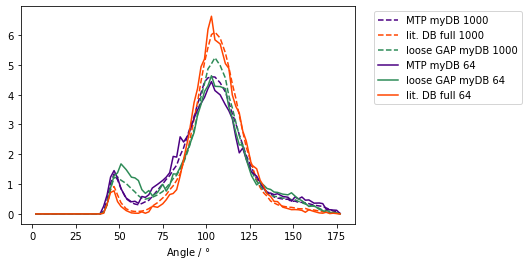

In [82]:
fig, axs = plt.subplots()
for i in targets[:3]:
    axs.plot(*MDs[i].bond_angle_av[1], label=target_labels[i], color=colors[i], linestyle='--')
for i in [1, 7, 10]:
    axs.plot(*MDs[i].bond_angle_av[1], label=target_labels[i], color=colors[i])


axs.legend(bbox_to_anchor=(1.04, 1), loc='upper left')
axs.set(xlabel='Angle / $\degree$')
fig.savefig('/home/joe/OneDrive/slack_figures/ang_methods_sizeeval.png', dpi=100, bbox_inches='tight')

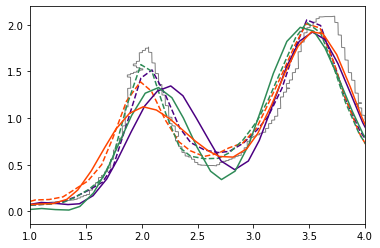

In [87]:
fig, axs = plt.subplots()
axs.plot(*aSi_exp_Sq, color='Gray', linewidth=1, label='Exp. a-Si')
for i in targets[:3]:
    axs.plot(*MDs[i].Sq_x_av[1], label=target_labels[i], color=colors[i], linestyle='--')
for i in [1, 7, 10]:
    axs.plot(*MDs[i].Sq_x_av[1], label=target_labels[i], color=colors[i])
#axs.set(xlabel= r'Q / $\mathrm{{\AA}}^{-1}$', ylabel='$S(Q)$')
axs.set(xlim=(1,4))
fig.savefig('/home/joe/OneDrive/slack_figures/Sq_methods_sizeeval_zoom.png', dpi=100, bbox_inches='tight')


# Effect of reducing the DB

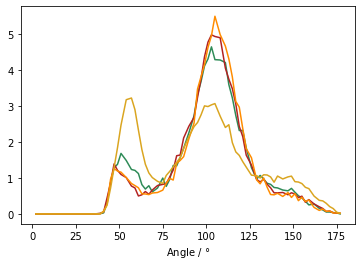

In [109]:
fig, axs = plt.subplots()
for i in targets_GAP:
    axs.plot(*MDs[i].bond_angle_av[1], label=target_labels[i], color=colors[i])

#axs.legend(bbox_to_anchor=(1.04, 1), loc='upper left')
axs.set(xlabel='Angle / $\degree$')
fig.savefig('/home/joe/OneDrive/slack_figures/ang_reduction_GAP64.png', dpi=100, bbox_inches='tight')

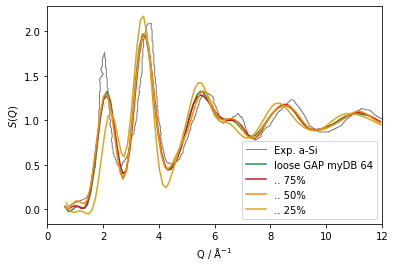

In [108]:
fig, axs = plt.subplots()
axs.plot(*aSi_exp_Sq, color='Gray', linewidth=1, label='Exp. a-Si')
for i in targets_GAP:
    axs.plot(*MDs[i].Sq_x_av[1], label=target_labels[i], color=colors[i])

axs.set(xlabel= r'Q / $\mathrm{{\AA}}^{-1}$', ylabel='$S(Q)$')
axs.set(xlim=(0,12))
axs.legend(loc='lower right')
fig.savefig('/home/joe/OneDrive/slack_figures/Sq_reduction_GAP64.png', dpi=100, bbox_inches='tight')

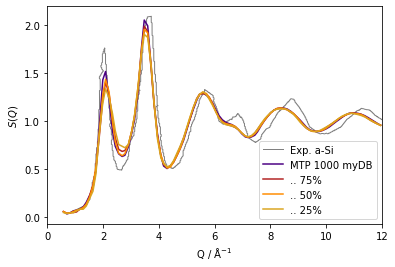

In [134]:
fig, axs = plt.subplots()
axs.plot(*aSi_exp_Sq, color='Gray', linewidth=1, label='Exp. a-Si')
for i in mlp_targets:
    axs.plot(*mlp_MDs[i].Sq_x_av[1], label=mlp_target_labels[i], color=mlp_colors[i])

axs.set(xlabel= r'Q / $\mathrm{{\AA}}^{-1}$', ylabel='$S(Q)$')
axs.set(xlim=(0,12))
axs.legend(loc='lower right')
fig.savefig('/home/joe/OneDrive/slack_figures/Sq_reduction_mlp1000.png', dpi=100, bbox_inches='tight')

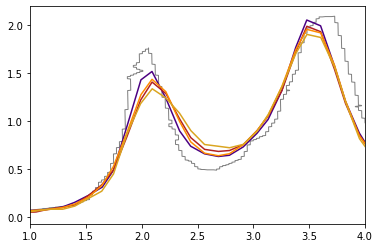

In [133]:
#zoom
fig, axs = plt.subplots()
axs.plot(*aSi_exp_Sq, color='Gray', linewidth=1, label='Exp. a-Si')
for i in mlp_targets:
    axs.plot(*mlp_MDs[i].Sq_x_av[1], label=mlp_target_labels[i], color=mlp_colors[i])

axs.set(xlim=(1,4))
fig.savefig('/home/joe/OneDrive/slack_figures/Sq_reduction_mlp1000_zoom.png', dpi=100, bbox_inches='tight')

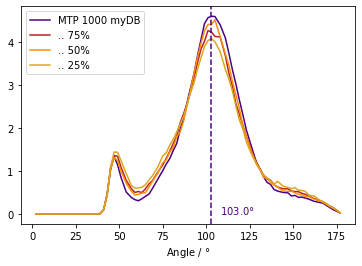

In [129]:
fig, axs = plt.subplots()
for i in mlp_targets:
    axs.plot(*mlp_MDs[i].bond_angle_av[1], label=mlp_target_labels[i], color=mlp_colors[i])
b = Si_mlp1000_MD.bond_angle_av[1]
max = b[0][b[1].argmax()]
axs.axvline(max, color='indigo', linestyle='--')
axs.text(max*1.05, 0, '${} \degree$'.format(str(max)), color='indigo')
#axs.legend(bbox_to_anchor=(1.04, 1), loc='upper left')
axs.set(xlabel='Angle / $\degree$')
fig.savefig('/home/joe/OneDrive/slack_figures/ang_reduction_mlp1000.png', dpi=100, bbox_inches='tight')

In [123]:
b = Si_mlp1000_MD.bond_angle_av[1]
max = b[0][b[1].argmax()]


In [122]:
max

103.0